In [ ]:
# Install spam -- this will ask you to restart the python runtime, you can do that safely.
!pip install spam==0.6.1.2

In [24]:
# Download data
!wget -O M2EA05-01-bin4.tif -q 'https://zenodo.org/record/7140837/files/M2EA05-01-bin4.tif?download=1'
!wget -O M2EA05-05-bin4.tif -q 'https://zenodo.org/record/7140837/files/M2EA05-05-bin4.tif?download=1'

# Introduction

As seen in the section in 2D imaging, to measure motion between two images of an evolving object two main principles can be used:

  1. **Particle Tracking**: Identification of the object in every time frame, followed by a temporal linking of identified objects. In the fluid mechanics world this is close to "PTV" (Particle Tracking Velocimetry). This family of techniques is extremely efficient when reliable object identifications can be made systematically for the material -- it is not only related to granular media: it can be effectively used to track pores, or inclusions in a matrix.
  
  2. **Image Correlation**: Tracking of greylevel texture using techniques based on greylevel conservation ("optical flow") the family of Digital Image Correlation (more correctly Digital Volume Correlation when comparing 3D images), which map into "PIV" (Particle Image Velocimetry) in fluid mechanics. This technique is much more general than particle tracking, requiring "texture" in both images, but can be applied very successfully to granular materials.

This section will discuss both methods with some examples, starting with a general introduction for Digital Volume Correlation to introduce a "global" measurement of strain which will be used to help a particle tracking approach. Finally image correlation will be also shown at the "micro" scale, for in 3D volumes where particles are identifiable, and when they are not.

Shape of im1 (Z,Y,X): (400, 250, 250)


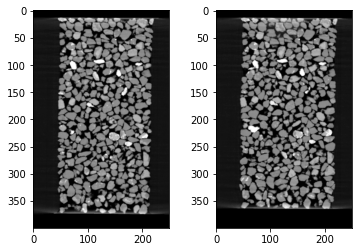

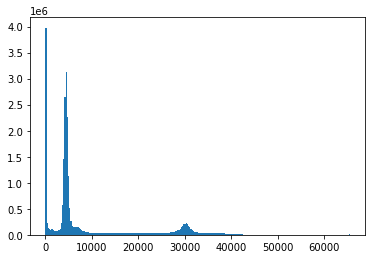

In [2]:
# Let's load some example data
import tifffile
import numpy
import matplotlib.pyplot as plt

im1 = tifffile.imread("M2EA05-01-bin4.tif").astype(float)
print(f"Shape of im1 (Z,Y,X): {im1.shape}")
im5 = tifffile.imread("M2EA05-05-bin4.tif").astype(float)

# Let's show some vertical slices
plt.subplot(1,2,1)
plt.imshow(im1[:,:,im1.shape[2]//2], cmap='Greys_r')
plt.subplot(1,2,2)
plt.imshow(im5[:,:,im5.shape[2]//2], cmap='Greys_r')
plt.show()

# Some vertical strain (being applied at the bottom) is visible!

plt.hist(im1.ravel(), bins=256, range=[0, 65535])
plt.show()

We see that the distribution of the greyvalues in the image has a peak at zero (mask of the outside of the sample), a gaussian-looking peak around 5000 which represents the air CT value and another gaussian peak at 30000 CT values which represents the most common CT value for the particles, although it's visible from the slices that there are some righter particles.


# Digital Image/Volume Correlation for registration

In this first section we will introduce Digital Volume Correlation in general, with the aim of mapping ("registering") a whole 3D volume into another, *i.e.*, to measure the overall deformation between the two volumes.

3D correlation libraries are not so easy to find, here we will use *spam* (https://pypi.org/project/spam/) that includes this functionality. Spam proposes a non-rigid registration trying to find the optimal linear deformation function $\Phi$ to map one image into the other.
$\Phi$ is expressed in homogeneous coordinates.

## Homogeneous coordinates and $\Phi$

$\Phi$ will be a 4x4 matrix as follows:

<img width="30%" src="https://zenodo.org/record/7140837/files/phi.png?download=1"></a>
                            
With 3D coordinates for a point:

$$ x = (\text{x},y,z) $$

we pad with a one and turn the coordinates into a column vector (this means we pass into a "homogeneous" coordinate system), to give:

<img width="15%" src="https://zenodo.org/record/7140837/files/x.png?download=1"></a>

We can then transform the coordinate with the deformation function $\Phi$ as follows:

$$ \Phi.x = x' $$


## Identity Matrix

A $\Phi$ which is the identity matrix does not deform the point

<img width="40%" src="https://zenodo.org/record/7140837/files/identity.png?download=1"></a>


### Translation

A simple translation of the point x is applied with components

$ t_x, t_y, t_z $

<img width="30%" src="https://zenodo.org/record/7140837/files/translation.png?download=1"></a>

When applied:

<img width="30%" src="https://zenodo.org/record/7140837/files/translation_applied.png?download=1"></a>

Remember that when dealing with differently binned images (see later), translations must be scaled, unlike linear transformations.


### Linear transformations (rotations, "zoom", "shear")

All remaining components of the transformation are found mixed together in the top left 3x3 matrix in $\Phi$, leading to our familiar, from continuum mechanics, transformation gradient tensor **F** (see previous tutorial).

For example uniaxial stretching can be performed by a change in the components along the diagonal of F:

<img width="30%" src="https://zenodo.org/record/7140837/files/zoom.png?download=1"></a>

Rotations in 3D can be quite complex.
There are a number of different ways of representing rotations in 3D -- see this very clear explanation on Wikipedia (https://en.wikipedia.org/wiki/Rotation_formalisms_in_three_dimensions). A simple example of a rotation around the z axis of a an angle $\theta$  would look like :

<img width="30%" src="https://zenodo.org/record/7140837/files/rotation.png?download=1"></a>

To represent rotations simply, we choose the *Rotation Vector* format, which is in the family of *axis-and-angle* representations.
A rotation vector is a three-component vector whose direction is the rotation axis and whose length is the rotation angle in degrees.


### Differences between images


In image correlation we have two images -- *im1* and *im2* which differ in some way.
We are looking for some $\Phi$ that makes *im1* and *im2* as similar as possible.
Here $x$ is a position vector:

$$ \text{im1}(x) = \text{im2}(\Phi.x) $$

or:

$$ \text{im1}(x) - \text{im2}(\Phi.x) = 0 $$

This is an important point to visualise: let's see what

$$ \text{im1}(x) - \text{im2}(x) $$

looks like for two different images :

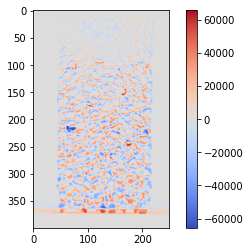

In [3]:
diff = im1[:,:,im1.shape[2]//2] - im5[:,:,im5.shape[2]//2]
plt.imshow(diff , cmap='coolwarm', vmin=-numpy.abs(diff).max(), vmax=numpy.abs(diff).max())
plt.colorbar()
plt.show()

Blue means a negative number, grey = 0 and red is positive.


We can see that there are differences between these images.
However there is some alignment -- especially the top of the sample seems good, and there is increasing mis-overlap as we go downwards towards 300.
This is relatively expected, since we are loading the sample from the bottom.
The middles of some particles have low error -- but there are problems on the edges.
Since the amount of dark and light voxels are approximately the same in the two images that have been subtracted, the sum of this image could be expected to be close to zero.

Under this transformation, this difference is clearly not zero.
If **im1** and **im2** have been acquired with a real measurement device which has some noise, even with the *a-priori* knowledge of Φ this difference will never be zero.
In what follows, the objective will be to find the transformation Φ that minimises this difference as far as possible.

If we'd like to define the difference between **im1** and **im2**, if we *square* the value of all the voxels in the difference, then low values will stay low, and highly negative and highly positive differences will both become highly positive.
The choice of the *square* particular makes sense for Gaussian noise.

$$ \left(\text{im1}(x) - \text{im2}(x)\right)^2 $$

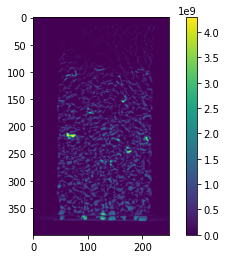

In [4]:
diff = im1[:,:,im1.shape[2]//2] - im5[:,:,im5.shape[2]//2]
plt.imshow(diff**2)
plt.colorbar()
plt.show()

Here low values are well matched, and high values are poorly matched.


### Image correlation -- Finding $\Phi$

We want to find $\Phi$. Since it has 12 unknowns (4×4 = 16 components, of which the bottom row is known), this is quite a complicated problem.
The first thing to do is to define an error *function* of Φ, which in this case is simply the classic *sum of squared difference* as introduced above, *i.e.,*

$$ \mathcal{T}(\Phi) = \frac{1}{2}\sum_{x \in ROI}{\left(\text{im1}(x) - \text{im2}(\Phi \cdot x)\right)^2} $$

$\mathcal{T}$ is a scalar function of the matrix $\Phi$.
The scalar returned is the sum-of-squares difference between **im1** and **im2** deformed by Φ.
*ROI* is a 3D region-of-interest in which we are calculating this error, and for which we will now try to find $\Phi$.
Since we're trying to measure a $\Phi$ in a small region, rather than for every voxel (which would be impossible), we have written a *weak* form of the solution.

Given this error function we can state our objective more clearly: we would like to find a Φ that minimises this error function.
In previous work we had searched the space of displacements, rotations, *etc.* making small steps (line searches) to decrease the error, but what follows is much faster and more robust:
we have implemented the incremental <cite data-cite="lucas1981iterative">(Lukas \& Kanade, 1981)</cite> approach for image correlation.
We use the formulation in homogeneous coordinates (*i.e.*, with $\Phi$) by the LMT in <cite data-cite="tudisco2017extension">(Tudisco et al., 2017)</cite>, build on previous work such as <cite data-cite="hild2012comparison">(Hild \& Roux, 2012)</cite>.

Let's try to measure a single Phi with the above approach to map the whole on image 1 into image 5.

Here we'll use the internal function programmed in spam, again, it is iterative, and will make progressive corrections to a guess initial $\Phi$ function.
The function will continue to iterate until the step size to correct Phi has become very small, or unless we hit a maximum number of iterations.

Furthermore, to save time and increase robustness we will use a "multiscale" approach, which is a very common way to formuate problems in image analysis.
In essence this means that we will downscale both images (8 times in this case) so that they are smaller, try to measure a $\Phi$, then downscale the original images only 4 times, and try to refine the $\Phi$, and repeat all the way back to the original images.

This means that a rough fit (which is not confused by fine details) is initially computed quickly computed (since there are fewer data and also less noisy, given the inherent averaging in downscaling images).
The multiscale process can be seen in the output below: please note that the final converged result at each scale is printed, with the current $\Phi$ decomposed into **t** (a translation vector), **r** (a rotation vector in degrees), and **z** (a change of size of axes)

In [5]:
import spam.DIC
import spam.deformation

registration = spam.DIC.registerMultiscale(im1, im5, 8, verbose=True, imShowProgress=False)

spam.DIC.correlate.registerMultiscale(): working on binning:  8


Start correlation with Error = 10860.94



	 -> Converged
spam.DIC.correlate.registerMultiscale(): working on binning:  4


Start correlation with Error = 3173.32



	 -> Converged
spam.DIC.correlate.registerMultiscale(): working on binning:  2


Start correlation with Error = 1599.93



	 -> Converged
spam.DIC.correlate.registerMultiscale(): working on binning:  1


Start correlation with Error = 1404.86



	 -> Converged


In [6]:
registration['Phi']

array([[ 0.975,  0.001,  0.006, -3.798],
       [-0.001,  1.018,  0.003, -0.032],
       [-0.007, -0.001,  1.019, -1.628],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

In [7]:
# Decompose Phi from registration to make it more understandable
PhiDecomposed = spam.deformation.decomposePhi(registration['Phi'])

names = [['t', 'Translation px (z, y, x)'],
         ['z', 'Axis stretch (z, y, x)'],
         ['r', 'Rotation vector deg (z, y, x)']]

for n, N in names:
    print(f"{N}:\n\t{PhiDecomposed[n]}\n")

Translation px (z, y, x):
	[-3.798 -0.032 -1.628]

Axis stretch (z, y, x):
	[0.9749452303793242, 1.0178265653802232, 1.0193113814636954]

Rotation vector deg (z, y, x):
	[-0.107  0.361 -0.042]



This allow the compression in Z to be seen (axis stretch in Z less than 1) with radial expansion in Y and X.

# Particle identification

Particle-based analysis clearly requires the particles to be uniquely identified, which is really **the** key step in our opinion for the analysis of granular geomaterials.

Here we will use a pretty standard technique to separate particles: first we will binarise the image into only black and white or true and false voxels (which will indicate the solid, granular phase *v.s.* everything else). Given the low noise in the image we can quite safely just apply a threshold CT value, around 20000.

Thereafter a 3D watershed algorithm will be applied. This was invented by <cite data-cite="beucher1979use">(Beucher, 1979)</cite>, and improved by <cite data-cite="beucher2018morphological">(Beucher \& Meyer, 2018)</cite>.
Here we're using the helper function from the *spam* library <cite data-cite="stamati2020spam">(Stamati et al, 2020)</cite> which implement's ITK's watershed <cite data-cite="beare2006watershed">(Beare et al., 2006)</cite>.
In short, in this sub-species of this method, we will first attempt to find "markers" in the inside of each particle in 3D.
This is achieved by working on the binary image - the 3D Euclidean distance map is computed on the grain phase, computing the distance for each grain-voxel to the other voxels.
This field is expected to increase towards the centre of grains, and in the case of quite rounded particles is expected to have a single peak in the middle of the particle.
Therefore the local maxima of the distance map are identified -- in order to have some robustness to convex but non-spherical shapes some nearby maxima can be merged into a single one.

Once this is done, each merged marker will be given a unique number (label), and these markers will be grown using the watershed algorithm and the Euclidean distance map until they cover all the solid phase and generally should only touch at the contacts.

There are subtle differences between "interpixel" algorithms and "watershed line" implementations: the interpixel will label all voxels of the grain phase as belonging to a label, whereas the watershed line will split particles at the contacts.
The algorithm used here is an interpixel one, so we'll get touching labels out directly.

Let's run the algorithm and see what happens!

In [8]:
# This is optional, the lines below will compute the labelled image, but it's a bit slow
!wget -O M2EA05-01-bin4-lab.tif -q 'https://zenodo.org/record/7140837/files/M2EA05-01-bin4-lab.tif?download=1'

The maximum value found in the labelled im1 is 3052
3052


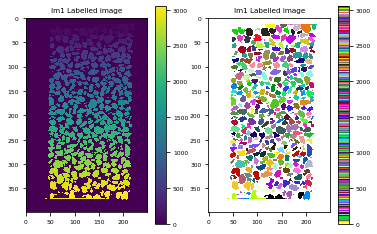

In [8]:
import spam.label
import os.path
import tifffile
import matplotlib.pyplot as plt

if os.path.isfile("M2EA05-01-bin4-lab.tif"):
  print("Reading existing file!")
  im1lab = tifffile.imread("M2EA05-01-bin4-lab.tif")
else:
  # This could take a few minutes...
  im1lab = spam.label.watershed(im1 > 20000)

# Let's see what happened
print(f"The maximum value found in the labelled im1 is {im1lab.max()}")

print(im1lab.max())

# Let's show some vertical slices
plt.subplot(1,2,1)
plt.title("Im1 Labelled image")
plt.imshow(im1lab[:,:,im1.shape[2]//2],
           interpolation='none')
plt.colorbar()
plt.subplot(1,2,2)
plt.title("Im1 Labelled image")
plt.imshow(im1lab[:,:,im5.shape[2]//2],
           cmap=spam.label.randomCmap,
           interpolation='none')
plt.colorbar()

plt.show()

How to interpret these images? In general labelling algorithms proceed down one direction, as can be seen no the left, label values seem to increase as Z increases.

On the right, we're using a special colourmap inspired by <cite data-cite="glasbey2007colour">(Glasbey et al, 2007)</cite> where each level of the colourmap is randomised to accentuate differences between nearby values.

What is visible here is that each grain pixel (identified previously with a greyscale threshold) has a label number; the non-grain phase has value 0 and each identified contiguous (i.e., touching) blob of voxels has a unique label number identifying it.

Generally the algorithm seems to have done a good job: there is a possible merged label in the middle of the volume (this is called undersegmentation), however oversegmentation (a real particle split into two or more labels) does not seem to be present.

A labelled image is a allows discrete analysis, but extracting and interrogating each label individually.
This is very easy to program, it simply means fetching all the voxels corresponding to a given label: thereafter a number of computations are easy, such as:

 - the barycentre of the object (the spatial average of the coordinates of each voxel)
 - the volume (the sum of the voxels)
 - Some shape/orientation descriptors such as the orientated caliper lengths or "feret diameters" or the moment of intertia
 
Other measurements on discretely voxelsied objects require a little more care:

 - surface area
 - interparticle contact presence and orientation
 
The article <cite data-cite="ando2018ease">(Andò \& Viggiani 2018)</cite> treats this exact problem in more detail.

As an illustration, the volume of each particle can be easily computed, allowing the diameter of the sphere of the same volume to be computed, from here a per-particle, particle size distribution can be computed.
Please note that the *2*15.56 represents the conversion between pixels and mm.

	plotParticleSizeDistribution(): Multiplying radii by two to make diameters


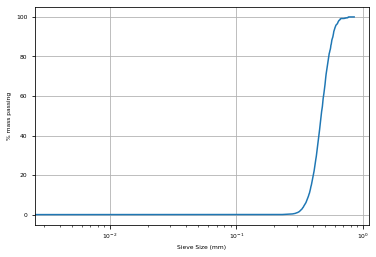

In [9]:
im1radii = spam.label.equivalentRadii(im1lab)

import spam.plotting
spam.plotting.plotParticleSizeDistribution(im1radii*2*15.56/1000,
                                           cumulative=True,
                                           cumulativePassing=True,
                                           mode="mass",
                                           logScaleX=True,
                                           logScaleY=False,
                                           units="mm")

You might have seen pictures where grains are coloured according to some scalar.
There are programmatically elegant ways to do this, but we can use a brute force approach here where all label values are simply replaced in a new image with corresponding values in a vector... for example the equivalnet radii would work:

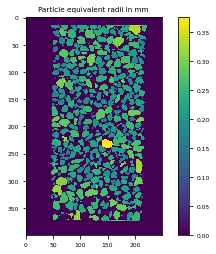

In [10]:
tmp = spam.label.convertLabelToFloat(im1lab[:, :, (im1.shape[2]//2)-2:(im1.shape[2]//2)+2],
                                     im1radii*2*15.56/1000)

plt.title("Particle equivalent radii in mm")
plt.imshow(tmp[:,:,2],
           interpolation='none')
plt.colorbar()
plt.show()


We can also use such measurements to make a quality control of the specimen... for example checking the spatial distribution of the large particles.

# Particle Tracking

For a particle tracking approach we need to identify objects in the other image.
It seems reasonable to keep the threshold the same, so let's compute im5label, and compare it to im1label:

The maximum value found in the labelled im1 is 3052
The maximum value found in the labelled im5 is 3035


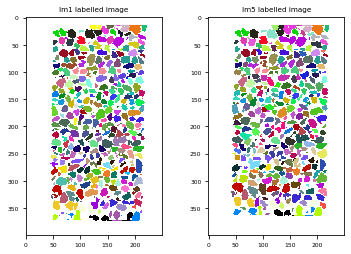

In [11]:
im5lab = spam.label.watershed(im5 > 20000)
print(f"The maximum value found in the labelled im1 is {im1lab.max()}")
print(f"The maximum value found in the labelled im5 is {im5lab.max()}")

plt.subplot(1,2,1)
plt.title("Im1 labelled image")
plt.imshow(im1lab[:,:,im1.shape[2]//2],
           cmap=spam.label.randomCmap,
           interpolation='none')
plt.subplot(1,2,2)
plt.title("Im5 labelled image")
plt.imshow(im5lab[:,:,im5.shape[2]//2],
           cmap=spam.label.randomCmap,
           interpolation='none')

plt.show()

Looking at label colours at the top (Z=low) of the volume, particle seem to have corresponding colours,
however this correspondence is lost towards the bottom of the volume.
This is either due to different amount of over- and under-segmentation in both images, which will make tracking difficult, or more benignly due to particle rearrangements (especially in the Z-direction) which will chang ethe sequencing of labels.

A particle tracking technique siply now becomes a question of linking labels in image 1 to labels in image 5.
This tracking/particle recognition can become quite sophisticated, but here we will just match particles based on nearest neighbours.
More sophisticated techniques such as ID-Track have been developed for geomaterials <cite data-cite="ando2012grain">(Andò et al., 2012)</cite>, but the generaly framework worth delving into is the  "Hungarian Method" <cite data-cite="kuhn1955hungarian">(Kuhn, 1955)</cite>.

This means that we will compute particle centers in image 1, apply the above-measured Phi to each centre to move it to an approximate position in image 5, and match each image 1 particle to the closest in image 5.


In [12]:
im1centers = spam.label.centresOfMass(im1lab)
# Each row in im1centers represents the z, y, x positions in pixels of the particle of that row number.
print(im1centers)
im5centers = spam.label.centresOfMass(im5lab)

[[  0.      0.      0.   ]
 [ 16.845  54.581 127.949]
 [ 19.901  84.51   64.063]
 ...
 [368.836 193.365 105.735]
 [370.304 183.124  73.776]
 [369.94  184.613  92.404]]


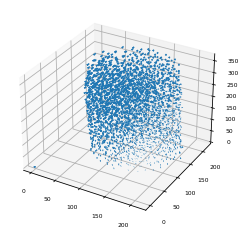

In [13]:
registrationDisplacements = spam.DIC.applyRegistrationToPoints(registration['Phi'],
                                                        (numpy.array(im1.shape) - 1) / 2.0,
                                                        im1centers,
                                                        applyF='no',
                                                        verbose=True)[:, 0:3, -1]

im1centersDeformed = im1centers + registrationDisplacements

ax = plt.figure().add_subplot(projection='3d')
ax.quiver(im1centers[:,2],
          im1centers[:,1],
          im1centers[:,0],
          registrationDisplacements[:,2],
          registrationDisplacements[:,1],
          registrationDisplacements[:,0],
          length=1,
          normalize=False)

plt.show()


In [14]:
import scipy.spatial

distanceMatrix = scipy.spatial.distance_matrix(im1centersDeformed, im5centers)

In [15]:
labelCorrespondence5_to_1 = numpy.zeros(distanceMatrix.shape[1])

for im5l in range(distanceMatrix.shape[1]):
    #print(numpy.argmin(distanceMatrix[im1l]))
    labelCorrespondence5_to_1[im5l] = numpy.argmin(distanceMatrix[:,im5l])

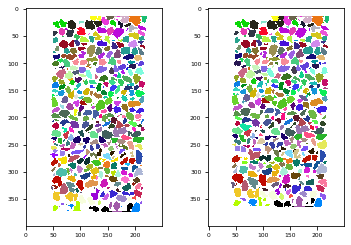

In [16]:
im5relab = spam.label.convertLabelToFloat(im5lab, labelCorrespondence5_to_1)
im5newcenters = spam.label.centresOfMass(im5relab)

# Let's show some vertical slices
plt.subplot(1,2,1)
plt.imshow(im1lab[:,:,im1.shape[2]//2],
           cmap=spam.label.randomCmap, interpolation='none')
plt.subplot(1,2,2)
plt.imshow(im5relab[:,:,im5relab.shape[2]//2],
           cmap=spam.label.randomCmap, interpolation='none')
plt.show()

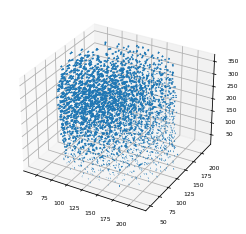

In [17]:
particleTrackingDisplacements = im1centers - im5newcenters

ax = plt.figure().add_subplot(projection='3d')
ax.quiver(im1centers[:,2],
          im1centers[:,1],
          im1centers[:,0],
          particleTrackingDisplacements[:,2],
          particleTrackingDisplacements[:,1],
          particleTrackingDisplacements[:,0],
          length=1,
          normalize=False)
plt.show()

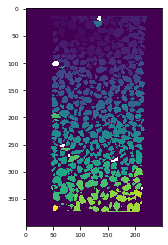

In [18]:
tmp = spam.label.convertLabelToFloat(im1lab[:, :, (im1.shape[2]//2)-2:(im1.shape[2]//2)+2],
                               numpy.sqrt(numpy.sum(numpy.square(particleTrackingDisplacements), axis=1)))
plt.imshow(tmp[:,:,2],
           interpolation='none')
plt.show()

# Discrete DVC

Now we will use **only** the labelled image in the reference configuration (im1lab) and adapt the earlier registration procedure to operate on a grain-by-grain basis.
In the language introduced above, we will perform one registration procedure per grain setting the ROI to be the label for each grain.
This "Discrete DVC" procedure was proposed in <cite data-cite="hall2009strain">(Hall et al., 2009)</cite> and has found a lot of success in image-based particle tracking.

It has the advantage that the labelled image is only used once and thus can be optimised and manually checked and corrected until it is almost as good as possible.

As before we will take into account the overall registration between image 1 and image 5 as the intial guess for particle displacements.

In [19]:
import spam.helpers
tifffile.imsave("M2EA05-01-bin4-lab.tif", im1lab)
spam.helpers.writeRegistrationTSV("M2EA05-01-05-bin4.tsv",
                                    (numpy.array(im1.shape) - 1) / 2.0,
                                    registration)
! spam-ddic "M2EA05-01-bin4.tif" "M2EA05-01-bin4-lab.tif" "M2EA05-05-bin4.tif" -pf "M2EA05-01-05-bin4.tsv"

spam-ddic -- Current Settings:
	APPLY_F: rigid
	CORRELATE_RIGID: True
	DEBUG: False
	INTERPOLATION_ORDER: 1
	LABEL_DILATE: 1
	MARGIN: 5
	MASK_OTHERS: True
	MAX_ITERATIONS: 50
	MIN_PHI_CHANGE: 0.001
	MULTISCALE_BINNING: 1
	OUT_DIR: ./
	PHIFILE: <_io.TextIOWrapper name='M2EA05-01-05-bin4.tsv' mode='r' encoding='UTF-8'>
	PHIFILE_BIN_RATIO: 1.0
	PREFIX: M2EA05-01-bin4-M2EA05-05-bin4
	PROCESSES: 2
	SKIP_PARTICLES: False
	UPDATE_GRADIENT: False
	VOLUME_THRESHOLD: 100
	im1: <_io.TextIOWrapper name='M2EA05-01-bin4.tif' mode='r' encoding='UTF-8'>
	im2: <_io.TextIOWrapper name='M2EA05-05-bin4.tif' mode='r' encoding='UTF-8'>
	lab1: <_io.TextIOWrapper name='M2EA05-01-bin4-lab.tif' mode='r' encoding='UTF-8'>

spam-ddic: Loading Data...done.
spam-ddic: Number of labels = 3052

spam-ddic: Calculating Bounding Boxes and Centres of Mass of all labels.


	I read a registration from a file in binning 1.0
	Translations (px)
		 [-3.798 -0.032 -1.628]
	Rotations (deg)
		 [-0.107  0.361 -0.042]
	Zoom
		 [0.9

	spam.tsvio.readCorrelationTSV(): Number of labels: 3053


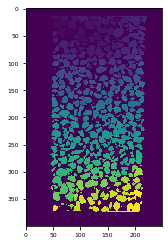

In [20]:
DDIC = spam.helpers.readCorrelationTSV("M2EA05-01-bin4-M2EA05-05-bin4-ddic.tsv")['PhiField']

tmp = spam.label.convertLabelToFloat(im1lab[:, :, (im1.shape[2]//2)-2:(im1.shape[2]//2)+2],
                                     numpy.sqrt(numpy.sum(numpy.square(DDIC[:,0:3,-1]), axis=1)))
plt.imshow(tmp[:,:,2],
           interpolation='none')
plt.show()

## Computing strains

What to do with this 3D displacement field? A natural question is to try to convert it into strains.

This is essentially a coarse-graining problem (mixed with a strain calculation problem).
The two main families of approaches are:

  - Grain based: particle centres are triangulated with an appropriate algorithm (Delaunay-style), making tetrahedra in 3D thus creating a basis on which strains can be calculated
  - Spatial: A 3D grid is computed and particle kinematics are computed on the grid, where cubic shape functions can be used to compute strains.
  
Both options are available in spam, and both will be illustrated now (although the tetrahedra; strains will be rendered with an external programme -- Paraview).

### Tetrahedra

In the case of dense, mono-disperse spherical packings a Delaunay triangulation will create tetrahedra whose vertices will be at the particle contacts. In the case of polydispersity, this is not respected, so adding a weight to the triangulation (making it a Radical Delaunay, or "Laguerre" triangulation) will help improve things.

Strains can be computed on this tetrahedral basis as per <cite data-cite="bagi1996stress">(Bagi, 1996)</cite> and later <cite data-cite="zhang2015large">(Zhang \& Regueiro, 2015)</cite>:

In [21]:
! spam-discreteStrain M2EA05-01-bin4-M2EA05-05-bin4-ddic.tsv -tri -a 300 -rl M2EA05-01-bin4-lab.tif

spam-discreteStrain -- Current Settings:
	COMPONENTS: ['vol', 'dev']
	KEEP_ZERO: False
	OUT_DIR: ./
	PREFIX: M2EA05-01-bin4-M2EA05-05-bin4-ddic-strains
	PROCESSES: 2
	PROJECT_TO_GRAINS: False
	RADII_LABELLED_FILE: M2EA05-01-bin4-lab.tif
	RADII_TSV_FILE: None
	RETURN_STATUS_THRESHOLD: None
	TRI: True
	TRI_ALPHA: 300.0
	TRI_FILE: None
	VTKmaskNAN: True
	inFile: <_io.TextIOWrapper name='M2EA05-01-bin4-M2EA05-05-bin4-ddic.tsv' mode='r' encoding='UTF-8'>

spam-discreteStrain: Loading kinematics...
	spam.tsvio.readCorrelationTSV(): Number of labels: 3053

spam-discreteStrain: 16336 tetrahedra created
spam-discreteStrain: 3052 nodes considered
spam-discreteStrain: Computing F=I+du/dx for all tetrahedra
100% ||

spam-discreteStrain: Decomposing F into  ['vol', 'dev'] for all tetrahedra
100% ||

spam-discreteStrain: Saving VTK strain fields...done.


This file is then loaded into paraview, showing a mesh of tetrahedra that link particle centres.
For this visualisation, the cylinder is cut in half to reveal tetrahedra, which are coloured either by the devatoric strains computed by the displacements of the four particles at each vertex, or volumetric strains:

<img width="50%" src="https://zenodo.org/record/7142405/files/meshStrains.jpg?download=1"></a>

This clearly shows some clear concentrations of deviatoric strain early in the test.
We can compare these fields to the grid processing method:

## Grid analysis

In [22]:
! spam-passPhiField -im1 M2EA05-01-bin4-lab.tif -ns 10 -vtk -pf M2EA05-01-bin4-M2EA05-05-bin4-ddic.tsv -tif
! spam-regularStrain M2EA05-01-bin4-M2EA05-05-bin4-ddic-passed-ns10.tsv -Q8 -rst 1 -tif



No labelled image so I'm in grid mode
Getting im1 dimensions by looking in the file (this ignores -im1shape)
spam-passPhiField -- Current Settings:
	APPLY_F: all
	CHECK_POINT_SURROUNDED: False
	LAB1: []
	MERGE_PREFER_LABEL: False
	NEIGHBOUR_RADIUS: None
	NS: [10, 10, 10]
	NUMBER_OF_NEIGHBOURS: None
	OUT_DIR: ./
	PHIFILE: <_io.TextIOWrapper name='M2EA05-01-bin4-M2EA05-05-bin4-ddic.tsv' mode='r' encoding='UTF-8'>
	PHIFILE2: []
	PHIFILE2_BIN_RATIO: 1
	PHIFILE_BIN_RATIO: 1.0
	PREFIX: M2EA05-01-bin4-M2EA05-05-bin4-ddic-passed-ns10
	PROCESSES: 2
	REGISTRATION_SUBTRACT_APPLY_F: rigid
	REGISTRATION_SUBTRACT_BIN_RATIO: 1
	REGISTRATION_SUBTRACT_FILE: None
	RETURN_STATUS_THRESHOLD: -4
	TIFF: True
	VTK: True
	im1: <_io.TextIOWrapper name='M2EA05-01-bin4-lab.tif' mode='r' encoding='UTF-8'>
	im1shape: (400, 250, 250)
	spam.tsvio.readCorrelationTSV(): Number of labels: 3053
Neither number of neighbours nor neighbour distance set, using default distance of 2*mean(NS) = 20

Starting Phi field interpo

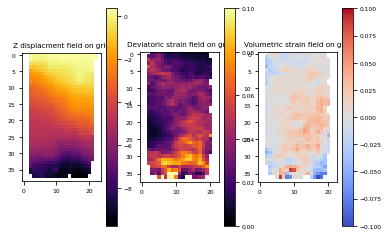

In [23]:
plt.subplot(1,3,1)
zField = tifffile.imread("M2EA05-01-bin4-M2EA05-05-bin4-ddic-passed-ns10-Zdisp.tif")
plt.title("Z displacment field on grid")
plt.imshow(zField[:,zField.shape[1]//2], cmap='inferno')
plt.colorbar()

plt.subplot(1,3,2)
devField = tifffile.imread("M2EA05-01-bin4-M2EA05-05-bin4-ddic-passed-ns10-dev-Q8.tif")
plt.title("Deviatoric strain field on grid")
plt.imshow(devField[:,devField.shape[1]//2], cmap='inferno', vmin=0, vmax=0.1)
plt.colorbar()

plt.subplot(1,3,3)
volField = tifffile.imread("M2EA05-01-bin4-M2EA05-05-bin4-ddic-passed-ns10-vol-Q8.tif")
plt.title("Volumetric strain field on grid")
plt.imshow(volField[:,volField.shape[1]//2], cmap='coolwarm', vmin=-0.1, vmax=0.1)
plt.colorbar()

plt.show()

It is our contention that these continous fields are easier to interpret.
A final question may come to mind: why not simply split the reference image into cubic correlation volumes (and not use the labelled image), since the displacement field is interpolated onto a regular grid using this method?
The fact of the matter is that the labelled image is the perfect definition of the objects that will move in this image, and so i the most pertinent base on which to do the tracking!